In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3
EPOCHS = 100
FILE_PATH  = "/content/drive/MyDrive/FYP/DATA_SET(Pea_Plant_Quality_Assesment)"

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 1464 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['DOWNY_MILDEW_LEAF', 'FRESH_LEAF', 'LEAFMINNER_LEAF', 'POWDER_MILDEW_LEAF']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 1 2 0 0 0 0 1 1 2 1 1 1 1 2 2 1 3 1 3 1 2 2 1 2 0 1 1 1 1 0]


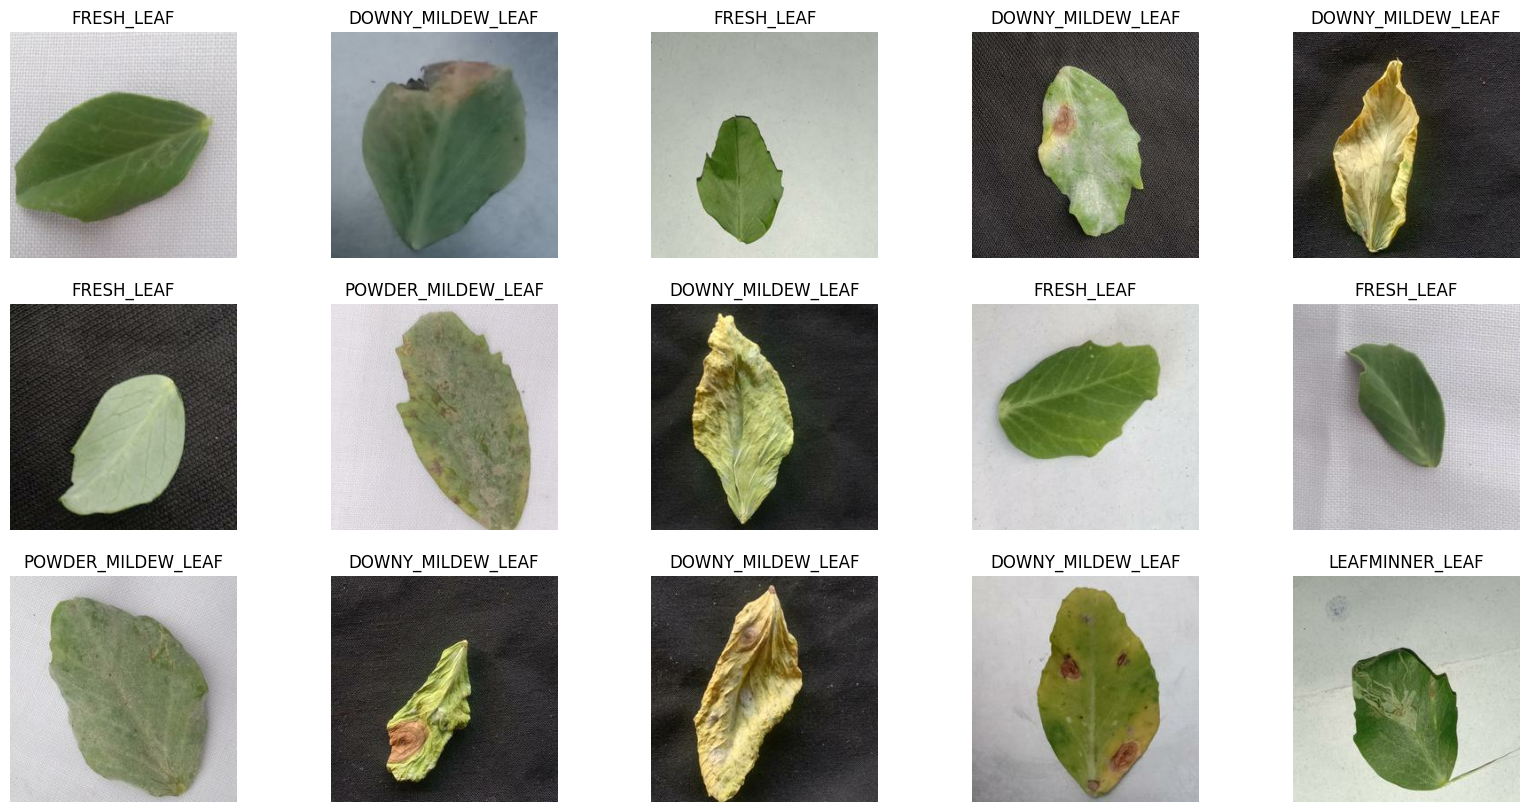

In [7]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)


    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds ,test_ds, valid_ds

In [9]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)

In [10]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [12]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [16]:
history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=EPOCHS
    )

Epoch 1/100
36/36 [==============================] - 382s 555ms/step - loss: 1.3382 - accuracy: 0.3168 - val_loss: 1.1348 - val_accuracy: 0.4531
Epoch 2/100
36/36 [==============================] - 2s 62ms/step - loss: 1.1750 - accuracy: 0.4696 - val_loss: 1.0837 - val_accuracy: 0.5000
Epoch 3/100
36/36 [==============================] - 2s 61ms/step - loss: 1.0233 - accuracy: 0.5599 - val_loss: 0.9172 - val_accuracy: 0.6016
Epoch 4/100
36/36 [==============================] - 2s 61ms/step - loss: 0.9351 - accuracy: 0.5946 - val_loss: 0.8265 - val_accuracy: 0.6172
Epoch 5/100
36/36 [==============================] - 2s 61ms/step - loss: 0.8758 - accuracy: 0.6363 - val_loss: 0.8968 - val_accuracy: 0.6094
Epoch 6/100
36/36 [==============================] - 2s 63ms/step - loss: 0.8916 - accuracy: 0.6302 - val_loss: 0.8935 - val_accuracy: 0.6094
Epoch 7/100
36/36 [==============================] - 2s 62ms/step - loss: 0.8516 - accuracy: 0.6337 - val_loss: 0.7210 - val_accuracy: 0.6953
Epo

In [17]:
scores = model.evaluate(test_ds)
scores

6/6 [==============================] - 3s 121ms/step - loss: 0.1582 - accuracy: 0.9348


[0.1581776887178421, 0.9347826242446899]

In [18]:
history

In [19]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 36}

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
history.history['accuracy']

[0.3168402910232544,
 0.4696180522441864,
 0.5598958134651184,
 0.5946180820465088,
 0.6362847089767456,
 0.6302083134651184,
 0.6336805820465088,
 0.6961805820465088,
 0.71875,
 0.7274305820465088,
 0.7604166865348816,
 0.7838541865348816,
 0.7751736044883728,
 0.7994791865348816,
 0.8090277910232544,
 0.8029513955116272,
 0.7942708134651184,
 0.8177083134651184,
 0.8116319179534912,
 0.8368055820465088,
 0.8385416865348816,
 0.8376736044883728,
 0.8263888955116272,
 0.8098958134651184,
 0.8168402910232544,
 0.8090277910232544,
 0.8359375,
 0.8472222089767456,
 0.8420138955116272,
 0.8515625,
 0.8628472089767456,
 0.8524305820465088,
 0.8532986044883728,
 0.8758680820465088,
 0.8680555820465088,
 0.8628472089767456,
 0.8845486044883728,
 0.8914930820465088,
 0.8828125,
 0.8958333134651184,
 0.8975694179534912,
 0.8993055820465088,
 0.8645833134651184,
 0.90625,
 0.8967013955116272,
 0.90625,
 0.9088541865348816,
 0.9262152910232544,
 0.9340277910232544,
 0.9140625,
 0.9045138955116272

In [22]:
len(history.history['accuracy'])

100

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

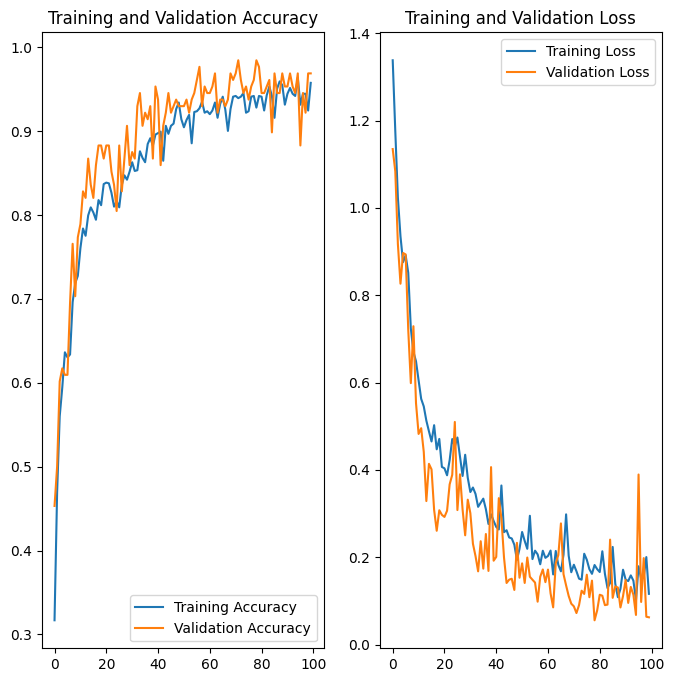

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: FRESH_LEAF
1/1 [==============================] - 0s 159ms/step
predicted label: FRESH_LEAF


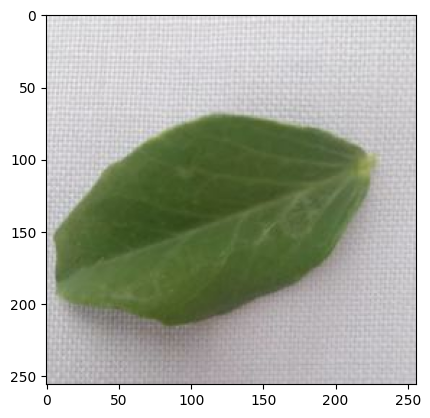

In [25]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [26]:
 #The purpose of this snippet is to provide a convenient way to make predictions on pea disease using a trained model
 #and obtain the predicted class label along with the confidence level of the prediction.

def predict_pea_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)


    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



1/1 [==============================] - 0s 22ms/step


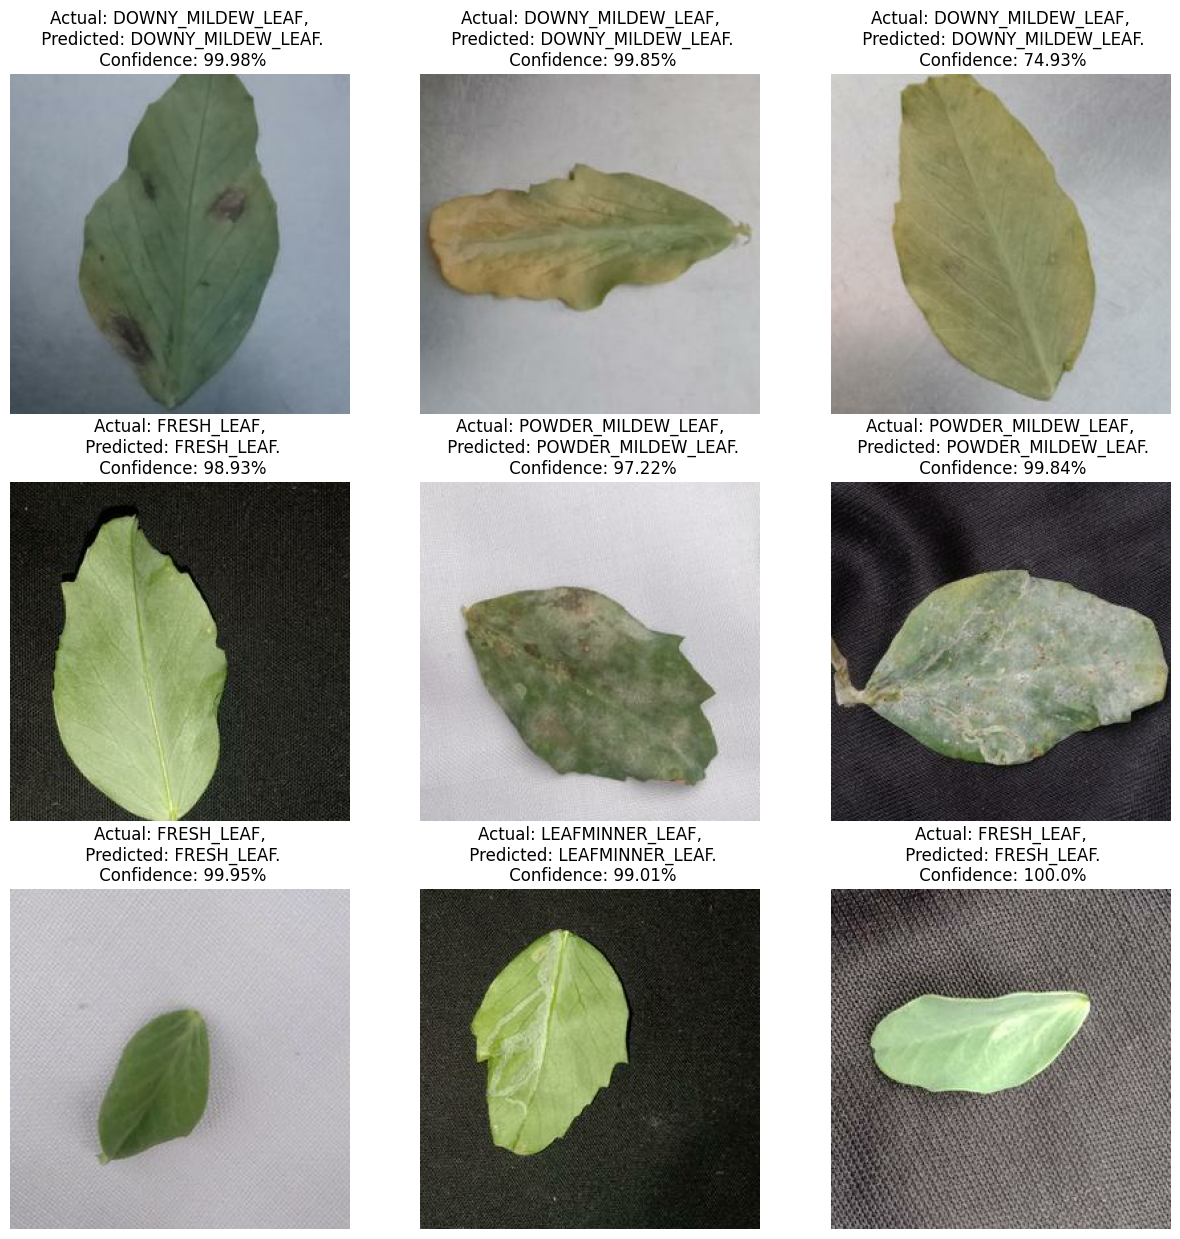

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict_pea_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**To Save model we will use the below Snippet**

In [28]:
#>>>>>>>>>>>          import os
#>>>>>>>>>>>          model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
#>>>>>>>>>>>          model.save(f"../models/{model_version}")

In [29]:
# Evaluate model performance on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

# Print the test loss and accuracy
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

6/6 [==============================] - 0s 27ms/step - loss: 0.1582 - accuracy: 0.9348
Test Loss: 0.1581776738166809
Test Accuracy: 0.9347826242446899


In [30]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert the true and predicted labels to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)

1/1 [==============================] - 0s 62ms/step
                    precision    recall  f1-score   support

 DOWNY_MILDEW_LEAF       0.86      0.94      0.90        47
        FRESH_LEAF       1.00      0.96      0.98        55
   LEAFMINNER_LEAF       0.91      0.89      0.90        47
POWDER_MILDEW_LEAF       0.97      0.94      0.96        35

          accuracy                           0.93       184
         macro avg       0.94      0.93      0.93       184
      weighted avg       0.94      0.93      0.94       184



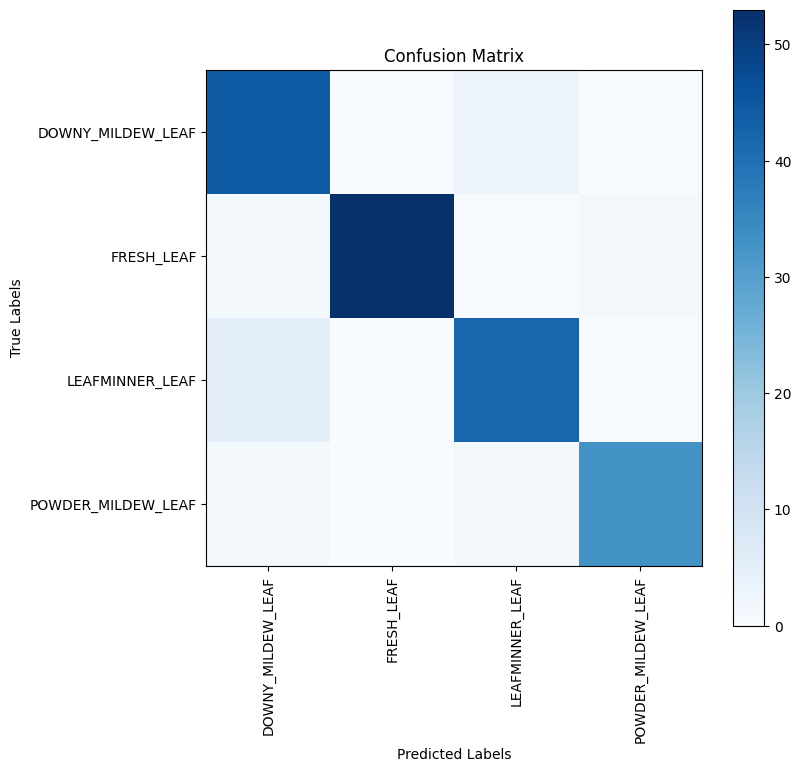

In [31]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[44  0  3  0]
 [ 1 53  0  1]
 [ 5  0 42  0]
 [ 1  0  1 33]]


In [33]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9347826086956522


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(y_true, y_pred, average='macro')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred, average='macro')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)

Precision: 0.9365942028985508
Recall: 0.934070185134015
F1 Score: 0.9347970526842497


1/1 [==============================] - 0s 39ms/step


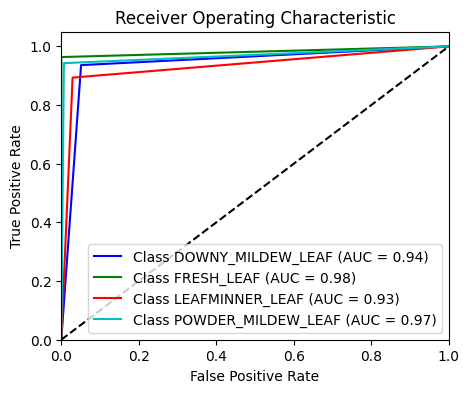

In [35]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test dataset
y_pred_prob = model.predict(test_ds)
y_test = []
y_pred = []

# Convert the predicted probabilities and true labels into one-hot encoded format
for images, labels in test_ds:
    y_test.extend(labels)
    y_pred.extend(np.argmax(model.predict(images), axis=-1))

y_test = label_binarize(y_test, classes=range(n_classes))
y_pred_prob = label_binarize(y_pred, classes=range(n_classes))

# Compute the ROC curve and area under the curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(5, 4))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
